import all required libraries, we use pandas to manage our data and use ARIMA model to predict the stock price

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import style

In [227]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

read in csv file

In [228]:
ms = pd.read_csv("HistoricalQuotes.csv")

In [229]:
ms['date']

0            16:00
1       2018/09/04
2       2018/08/31
3       2018/08/30
4       2018/08/29
5       2018/08/28
6       2018/08/27
7       2018/08/24
8       2018/08/23
9       2018/08/22
10      2018/08/21
11      2018/08/20
12      2018/08/17
13      2018/08/16
14      2018/08/15
15      2018/08/14
16      2018/08/13
17      2018/08/10
18      2018/08/09
19      2018/08/08
20      2018/08/07
21      2018/08/06
22      2018/08/03
23      2018/08/02
24      2018/08/01
25      2018/07/31
26      2018/07/30
27      2018/07/27
28      2018/07/26
29      2018/07/25
           ...    
2489    2008/10/15
2490    2008/10/14
2491    2008/10/13
2492    2008/10/10
2493    2008/10/09
2494    2008/10/08
2495    2008/10/07
2496    2008/10/06
2497    2008/10/03
2498    2008/10/02
2499    2008/10/01
2500    2008/09/30
2501    2008/09/29
2502    2008/09/26
2503    2008/09/25
2504    2008/09/24
2505    2008/09/23
2506    2008/09/22
2507    2008/09/19
2508    2008/09/18
2509    2008/09/17
2510    2008

remove the first row of dataset in order to make 'date' be the index

In [232]:
ms = ms.drop(0)

In [233]:
ms['date'] =  pd.to_datetime(ms['date'])

In [234]:
ms = ms.set_index('date')

In [235]:
ms.head()

,close,volume,open,high,low
date,,,,,
2018-09-04,111.71,22558040.0000,110.850,111.955,110.220
2018-08-31,112.33,23217310.0000,111.685,112.777,111.515
2018-08-30,111.95,22759640.0000,111.670,112.610,111.440
2018-08-29,112.02,20747500.0000,110.450,112.030,110.270
2018-08-28,110.26,19144860.0000,109.940,110.500,109.790


In [236]:
ms.tail()

,close,volume,open,high,low
date,,,,,
2008-09-10,26.44,75042030.0000,26.52,26.86,26.25
2008-09-09,26.10,85693570.0000,26.20,26.60,26.05
2008-09-08,26.12,62109170.0000,26.21,26.33,25.67
2008-09-05,25.65,82222430.0000,26.03,26.22,25.63
2008-09-04,26.35,66138490.0000,26.74,26.89,26.35


draw the diagram of the close price of stock from 2008 to 2018

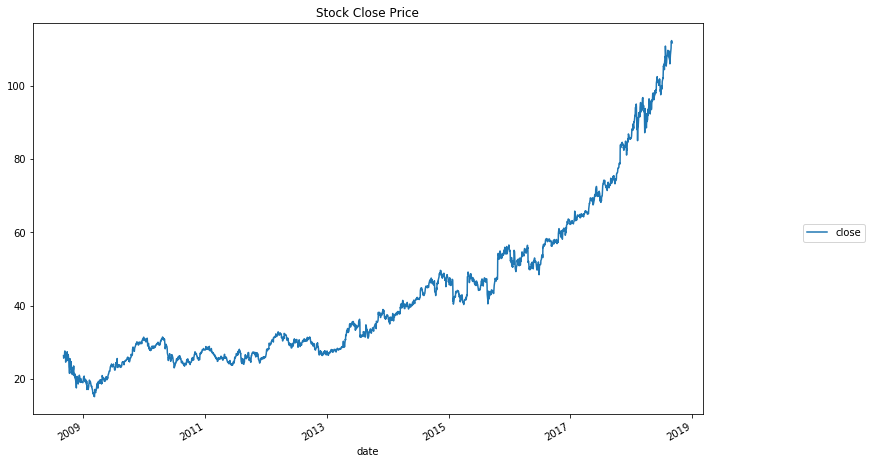

In [292]:
ms['close'].plot(figsize=(12,8))
plt.legend(bbox_to_anchor=(1.25, 0.5))
plt.title("Stock Close Price")
plt.show()

Resample time series in pandas to a weekly interval

In [238]:
stock_week = ms['close'].resample('W-MON').mean()

In [239]:
stock_train = stock_week['2012':'2018']

Diagram of stock price in 2018

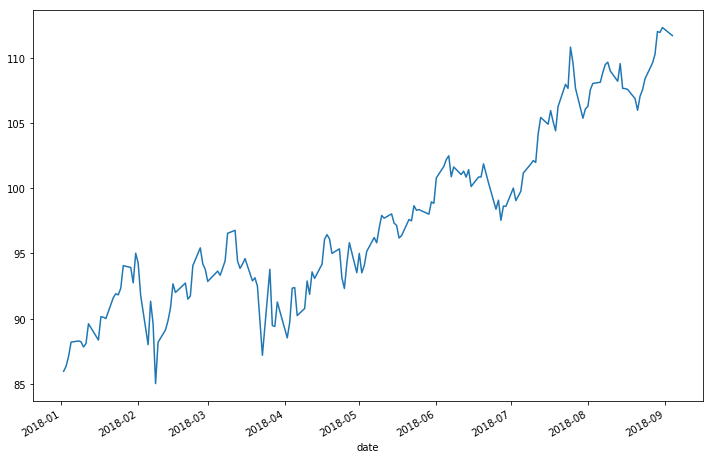

In [240]:
ms['close'].loc['2018'].plot(figsize=(12,8))
plt.show()

Calculate the total price increase rate from 2008 to 2018

In [293]:
price_increase_rate = (ms['close'][0] - ms['close'][-1])/ms['close'][-1]
price_increase_rate

3.2394686907020867

In [294]:
total_year = ms.index[0].year - ms.index[-1].year
total_year

10

Annual growth rate

In [243]:
annual_growth_rate = price_increase_rate**(1/total_year)
annual_growth_rate

1.1247276677047469

Diagram of stock price in the begining of each year

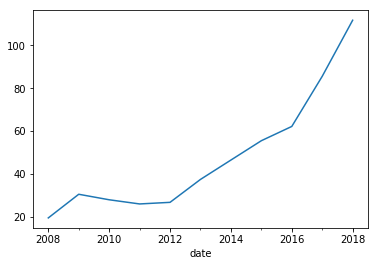

In [295]:
ms['close'].to_period('A').groupby(level = 0).first().plot()

Setup rolling windows for 42days average and 250days average of stock price.

In [296]:
ms['42d'] = ms['close'].rolling(window=42).mean()
ms['250d'] = ms['close'].rolling(window=250).mean()

Diagram of 42days average, 250days average and real close price.
In the short run,close price would normally be decreasing when the 42days price is below 250days price.

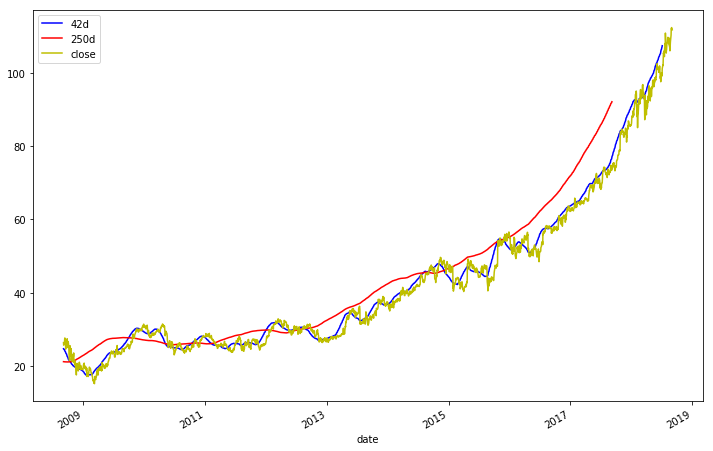

In [297]:
ms[['42d', '250d', 'close']].plot(figsize=(12,8), color=['b', 'r', 'y'])

Calculate the first order difference

In [298]:
ms['log-returns'] = np.log(ms['close']/ms['close'].shift(1))

When the log-returns is oscillating dramatically, we can see the close price would be normally decreasing.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c283dab38>,
      dtype=object)

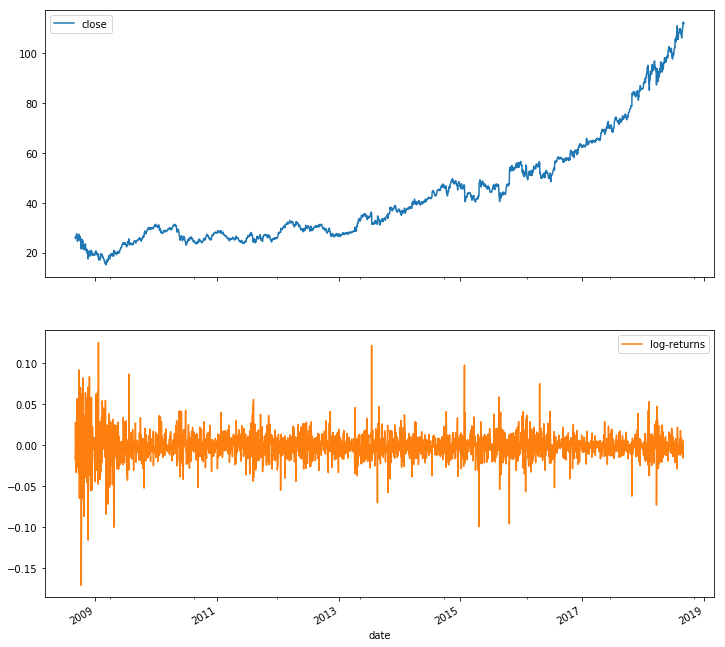

In [299]:
ms[['close', 'log-returns']].plot(subplots=True, figsize=(12,12))

Using matplotlib draw the diagram the first order difference. (Same as above)

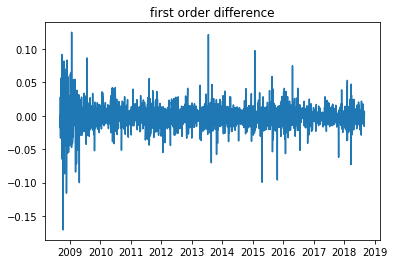

In [300]:
plt.figure()
plt.plot(ms['log-returns'])
plt.title('first order difference')
plt.show()

Using autocorrelation function and partial autocorrelation function to find the pattern of data. 
From the diagram, we can get p = 0 abd q = 1. 

p: The number of lag observations included in the model, also called the lag order. 
d: The number of times that the raw observations are differenced, also called the degree of differencing.(in this case d=1) 
q: The size of the moving average window, also called the order of moving average. 

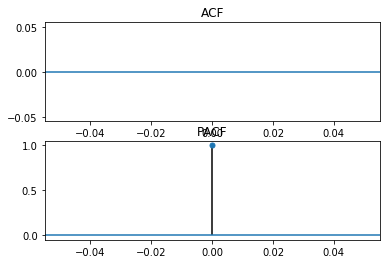

In [303]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
plot_acf(stock_diff, lags=120,ax=ax1,title="ACF")
plot_pacf(stock_diff, lags=120,ax=ax2,title="PACF")
plt.show()

Setup the ARIMA model

In [285]:
model = ARIMA(stock_train, order=(0, 1, 1), freq='W-MON')

In [286]:
result = model.fit()

The result of prediction from 2018-09-03 to 2019-01-07

In [305]:
pred = result.predict('2018-09-03', '2019-01-07',dynamic=True,typ='levels')
pred.head(50)

2018-09-03    107.946392
2018-09-10    108.192348
2018-09-17    108.438303
2018-09-24    108.684258
2018-10-01    108.930214
2018-10-08    109.176169
2018-10-15    109.422124
2018-10-22    109.668080
2018-10-29    109.914035
2018-11-05    110.159990
2018-11-12    110.405946
2018-11-19    110.651901
2018-11-26    110.897856
2018-12-03    111.143812
2018-12-10    111.389767
2018-12-17    111.635722
2018-12-24    111.881678
2018-12-31    112.127633
2019-01-07    112.373588
Freq: W-MON, dtype: float64

Diagram of prediction of stock close price. (Miscrosoft)

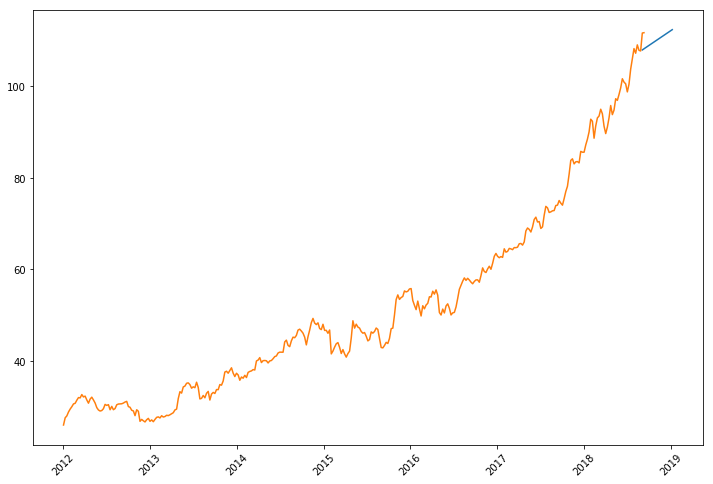

In [289]:
plt.figure(figsize=(12, 8))
plt.xticks(rotation=45)
plt.plot(pred)
plt.plot(stock_train)
plt.show()